In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run: pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import sys
import matplotlib.ticker as mticker
import sectionate
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client
import glob
import cmocean.cm as cmo
from tqdm import tqdm
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
sns.set_style("darkgrid")

print(f"Sectionate version: {sectionate.__version__}")
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

Sectionate version: 0.2.2
xgcm version 0.8.2.dev52+g5398098 
regionate version 0.3.3 
xwmt version 0.1.0 
xwmb version 0.3.0


In [3]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev52+g5398098 
regionate version 0.3.3 
xwmt version 0.1.0 
xwmb version 0.3.0


In [4]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/" + x
datafiles = glob.glob(datadir("CM4Xp125*"))[20:]
datafiles = sorted(datafiles)[26:32]

In [5]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='50GB',
    walltime='02:00:00',
    queue='scavenger',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=6)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p scavenger
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=47G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.90:33933 --name dummy-name --nthreads 36 --memory-limit 46.57GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.90:33933,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [44]:
def get_transports(ds):
    ds_sub = ds[["umo", "vmo", "thkcello", "sigma2_i", "zos"]]

    return ds_sub
    
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
ds = xr.open_mfdataset(
        # datadir("model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_*.zarr"),
        datafiles,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        preprocess = get_transports, 
        engine="zarr")
ds = ds.mean("time").compute()
# ds = ds.where(ds.wet > 0).where(ds.wet_v > 0).fillna(0.0)
ds["z"] = approximate_z_top_down(ds, dim = "sigma2")
grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")

In [45]:
zrho_start = ds["z"].mean("xh", skipna = True).compute()

In [46]:
vmo  = ds['vmo']
vmo_xsum = vmo.sum(dim='xh', skipna = True) 
psi      = (vmo_xsum.cumsum(dim='sigma2_l') - vmo_xsum.sum(dim='sigma2_l'))/1e9 
psi.name = 'meridional-sigma2 overturning'

# defined by zonal mean of the time mean depth of rho
psi_depth = grid.interp(zrho_start, 'Y', boundary='extend').rename("depth").compute()

# psi = xr.merge([psi, psi_depth])
psi = psi.assign_coords({'depth': psi_depth})
psi['geolat'] = xr.ones_like(psi['depth'].isel(exp = 0).drop_vars("exp")) * ds["geolat_v"].mean(dim='xh')
psi = psi.compute()

Text(0.5, 1.0, "Global Streamfunction\n(don't mask empty cells)")

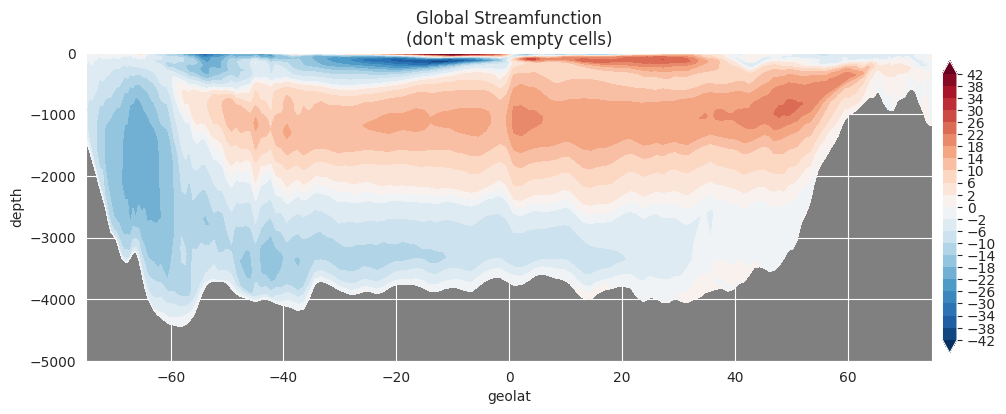

In [47]:
#define streamfunction levels
levels = [-42, -38, -34, -30, -26, -22, -18, -14, -10, -6, -2, 
           0,   2,   6,  10,  14,  18,  22,  26,  30,  34,  38,  42]

#select experiment 
exp = "control"

# create one figure with two subplots
fig, ax = plt.subplots(figsize=(13, 4), sharey=True)

# first subplot: depth
p1 = psi.sel(exp=exp).plot.contourf(
    ax=ax, x="geolat", y="depth", levels=levels,
    add_colorbar=False, cmap='RdBu_r', extend = "both"
)
c1 = fig.colorbar(p1, ax=ax, pad=0.01, spacing='uniform',
                  extend='both', shrink=0.95, orientation='vertical')
c1.set_ticks(levels)
c1.ax.tick_params(labelsize=10)
ax.set_facecolor('gray')
ax.set_xlim(-75, 75) #required for some reason 
ax.set_ylim(-5000, 0) #required for some reason 
# ax.invert_yaxis()
ax.set_title("Global Streamfunction\n(don't mask empty cells)")

In [66]:
def meridonal_average_by_lat(scalar: xr.DataArray, grid, lat: float) -> xr.DataArray:
    """
    Compute the zonal (and meridional) average of a scalar field *at* a given latitude band.
    
    Parameters
    ----------
    scalar : xr.DataArray
        Any scalar field on the same grid as grid._ds (e.g. ds["z"], ds["thk"], ds["zos"]).
    grid : your grid object
        Must expose grid._ds["geolat_v"] and support grid.diff(..., axis="Y").
    lat : float
        Latitude (°N) at which to extract the zonal average.
    
    Returns
    -------
    avg : xr.DataArray
        The mean profile of `scalar` versus vertical level, tagged with a coordinate `lat=lat`.
    """
    geolat_v = grid._ds["geolat_v"]
    # mask of cells crossing the specified latitude
    diff_lat_mask = np.abs(
        grid.diff((geolat_v >= lat).astype(float), axis="Y")
    )
    diff_lat_mask = diff_lat_mask.where(diff_lat_mask > 0)

    # weighted mean over the horizontal dims
    avg = (scalar * diff_lat_mask).mean(["xh", "yh"], skipna=True)
    return avg.assign_coords(lat=lat)


def meridional_streamfunction_at_lat(grid, lat: float, div_v = None) -> xr.DataArray:
    """
    Compute the meridional volume‐transport streamfunction (Psi) at a given latitude.
    
    Parameters
    ----------
    grid : your grid object
        Must expose grid._ds["vmo"] and support grid.diff(..., axis="Y", boundary="fill").
    geolat : xr.DataArray
        The cell‐center latitude field (e.g. ds.geolat), same horizontal dims as vmo.
    lat : float
        Latitude (°N) at which to compute the cumulative transport.
    
    Returns
    -------
    psi : xr.DataArray
        Psi vs. vertical level in Sverdrups (Sv), tagged with a coordinate `lat=lat`.
    """
    # 1) meridional divergence of vmo
    geolat = grid._ds["geolat"]
    if div_v is None:
        print("no divV provied")
        div_v = (
            grid
            .diff(grid._ds["vmo"].fillna(0.0), axis="Y", boundary="fill")
            .fillna(0.0))

    # 2) sum divergence northward of 'lat'
    psi_lat = (div_v * (geolat >= lat))
    psi_lat = psi_lat.where(psi_lat != 0).sum(["xh", "yh"], skipna=True)

    # 3) integrate from bottom up and convert to Sv
    psi_lat = (psi_lat.cumsum("sigma2_l") - psi_lat.sum("sigma2_l")) / 1e9

    return psi_lat.compute().assign_coords(lat=lat)

def meridional_streamfunction(grid, lats: np.ndarray, div_v = None) -> xr.DataArray:
    
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        warnings.simplefilter(action='ignore', category=UserWarning)

        grid._ds["geolat_v"] = grid._ds["geolat_v"].compute()
        grid._ds["geolat"] = grid._ds["geolat"].compute()

        psi = xr.concat([meridional_streamfunction_at_lat(grid, lat, div_v = div_v) for lat in tqdm(lats, desc="Computing ψ by latitude")], dim = "lat").sortby("lat") 
        depth = xr.concat([meridonal_average_by_lat(grid._ds["z"], grid, lat) for lat in tqdm(lats, desc="Computing z by latitude")], dim = "lat").sortby("lat") 

        psi_ds = -psi.rename("psi").to_dataset()
        psi_ds = psi_ds.assign_coords({'depth': depth})
        psi_geolat = xr.ones_like(psi_ds['depth'].isel(exp = 0).drop_vars("exp")) * psi_ds["lat"]
        psi_ds = psi_ds.assign_coords({'geolat': psi_geolat})

    return psi_ds

In [70]:
div_v = grid.diff(grid._ds["vmo"].fillna(0.0), axis = "Y", boundary = "fill").fillna(0.0)

lats = np.arange(-89, -60, 1)
psi = meridional_streamfunction(grid, lats, div_v = div_v).compute()

Computing z by latitude: 100%|██████████| 29/29 [00:04<00:00,  5.94it/s]


Text(0.5, 1.0, "Global Streamfunction\n(don't mask empty cells)")

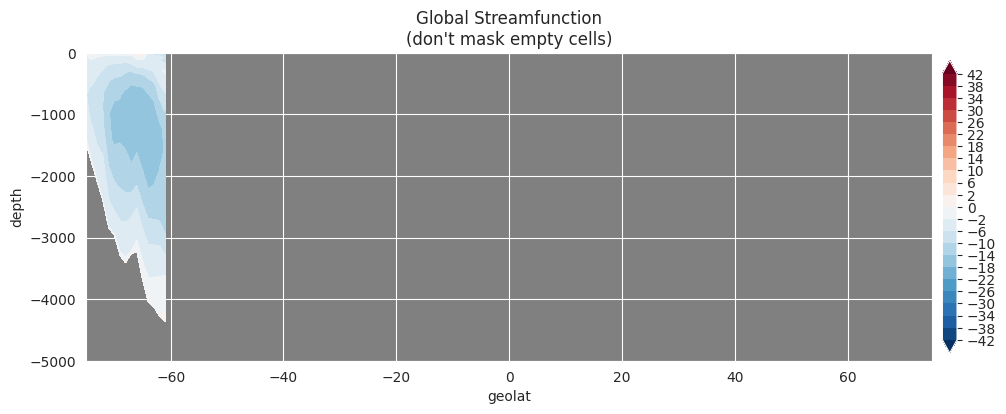

In [71]:
#define streamfunction levels
levels = [-42, -38, -34, -30, -26, -22, -18, -14, -10, -6, -2, 
           0,   2,   6,  10,  14,  18,  22,  26,  30,  34,  38,  42]

#select experiment 
exp = "forced"

# create one figure with two subplots
fig, ax = plt.subplots(figsize=(13, 4), sharey=True)

# first subplot: depth
p1 = psi["psi"].sel(exp=exp).plot.contourf(
    ax=ax, x="geolat", y="depth", levels=levels,
    add_colorbar=False, cmap='RdBu_r', extend = "both"
)
c1 = fig.colorbar(p1, ax=ax, pad=0.01, spacing='uniform',
                  extend='both', shrink=0.95, orientation='vertical')
c1.set_ticks(levels)
c1.ax.tick_params(labelsize=10)
ax.set_facecolor('gray')
ax.set_xlim(-75, 75) #required for some reason 
ax.set_ylim(-5000, 0) #required for some reason 
# ax.invert_yaxis()
ax.set_title("Global Streamfunction\n(don't mask empty cells)")